In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sage import MarginalImputer, PermutationEstimator

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import brier_score_loss

from oob_methods import compute_oob_fis
from data_generator import generate_noised_led_sample

In [2]:
flip_proba = 0.2
irrelevant_probas = [0.5] # Add an irrelevant binary feature of distribution Ber(0.5)
n_feature = 7 + len(irrelevant_probas)
idx_target = 5
idx_features = [i for i in range(n_feature + 1) if i != idx_target]
rng = np.random.RandomState(42)

In [3]:
def run_asymptotic_analysis(sample_sizes, n_simulations=50, test_size=500, n_estimators=50):
    """
    Run feature importance analysis across different sample sizes.
    
    Parameters:
    -----------
    sample_sizes : list
        List of training sample sizes to test
    n_simulations : int
        Number of simulations per sample size
    test_size : int
        Fixed test set size
    n_estimators : int
        Number of trees in random forest
    
    Returns:
    --------
    dict : Results organized by sample size and method
    """
    results = {
        'sample_sizes': sample_sizes,
        'mdi_rf': {},
        'ufi': {},
        'mdi_oob': {},
        'naive_oob': {},
        'j_score': {},
        'sage': {},
        'mdi_et': {},
        'loss_improvement': {}
    }
    
    for train_size in sample_sizes:
        print(f"Processing sample size: {train_size}")
        
        # Initialize storage for this sample size
        results['mdi_rf'][train_size] = []
        results['ufi'][train_size] = []
        results['mdi_oob'][train_size] = []
        results['naive_oob'][train_size] = []
        results['j_score'][train_size] = []
        results['sage'][train_size] = []
        results['mdi_et'][train_size] = []
        results['loss_improvement'][train_size] = []
        
        for sim in range(n_simulations):
            # Generate data
            X, y = generate_noised_led_sample(
                n_sample=train_size + test_size,
                irrelevant=irrelevant_probas,
                flip_proba=flip_proba,
                random_state=rng,
            )
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=test_size, shuffle=True, random_state=rng
            )
            
            # Train Random Forest model
            rfc = RandomForestClassifier(
                n_estimators=n_estimators,
                oob_score=True,
                n_jobs=-1,
                random_state=rng,
            ).fit(X_train, y_train)
            
            # Compute feature importances
            results['mdi_rf'][train_size].append(rfc._unnormalized_feature_importances)
        
            feature_importance_res = compute_oob_fis(
                rfc,
                X_train,
                y_train,
                brier_score_loss,
                ["UFI", "MDI-oob", "j-score", "naive-oob"],
                is_classif=True
            )
            
            results['ufi'][train_size].append(feature_importance_res["UFI"])
            results['mdi_oob'][train_size].append(feature_importance_res["MDI-oob"])
            results['j_score'][train_size].append(feature_importance_res["j-score"])
            results['naive_oob'][train_size].append(feature_importance_res["naive-oob"])
            
            # Train Extra Trees model
            etc = ExtraTreesClassifier(
                n_estimators=n_estimators,
                max_features=1,
                n_jobs=-1,
                random_state=rng,
            ).fit(X_train, y_train)
            
            dummy = DummyClassifier(strategy="prior").fit(X_train, y_train)
            
            # Compute loss improvement
            model_loss = brier_score_loss(y_test, etc.predict_proba(X_test))
            dummy_loss = brier_score_loss(y_test, dummy.predict_proba(X_test))
            loss_improvement = dummy_loss - model_loss
            results['loss_improvement'][train_size].append(loss_improvement)

            # SAGE values
            imputer = MarginalImputer(etc, X_test[:500])
            estimator = PermutationEstimator(imputer, "mse", random_state=rng)
            results['sage'][train_size].append(estimator(X_test, np.eye(len(np.unique(y_test)))[y_test], thresh=0.1, bar=False).values)
            
            # MDI
            results['mdi_et'][train_size].append(etc._unnormalized_feature_importances)

    
    return results

def plot_asymptotic_behavior(results, figsize=(15, 15)):
    """
    Create comprehensive plots showing asymptotic behavior.
    
    Parameters:
    -----------
    results : dict
        Results from run_asymptotic_analysis
    figsize : tuple
        Figure size
    
    Returns:
    --------
    tuple : (fig1, fig2) - Individual features plot and summary plot
    """
    sample_sizes = results['sample_sizes']
    
    # Plot the importance of each feature and their sum for the Random Forest model
    methods = ['mdi_rf', 'ufi', 'mdi_oob', 'naive_oob', 'j_score',]
    method_names = ['MDI', 'UFI', 'MDI-OOB', 'Naive-OOB', 'J-Score']
    
    n_feature = len(results['mdi_rf'][100][0])
    min_plot = 0
    max_plot = 0

    # Create figure for individual features
    fig1, axes = plt.subplots(3, 3, figsize=figsize)
    axes = axes.flatten()
    
    # Plot each feature's evolution
    for feat_idx in range(n_feature):
        ax = axes[feat_idx]
        
        for method, method_name in zip(methods, method_names):
            means = []
            lower_bounds = []
            upper_bounds = []
            
            for sample_size in sample_sizes:
                # Extract importance values for this feature across simulations
                feature_importances = []
                for sim_result in results[method][sample_size]:
                    feature_importances.append(sim_result[feat_idx])
                
                mean_val = np.mean(feature_importances)
                std_val = np.std(feature_importances)
                
                means.append(mean_val)
                lower_bounds.append(mean_val - std_val)
                upper_bounds.append(mean_val + std_val)
            
            min_plot = min(min(lower_bounds), min_plot)
            max_plot = max(max(upper_bounds), max_plot)
            
            line = ax.plot(sample_sizes, means, label=method_name, marker='o', markersize=4, alpha=0.8)[0]
            ax.fill_between(sample_sizes, lower_bounds, upper_bounds, alpha=0.2, color=line.get_color())
        
        ax.set_title(f'Feature {feat_idx}' + (' (noise)' if feat_idx==7 else ''))
        ax.set_xlabel('Training Sample Size (log scale)')
        ax.set_ylabel('Importance Score')
        ax.set_xscale('log')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)
        
        # Add horizontal line at zero
        ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    for feat_idx in range(n_feature):
        axes[feat_idx].set_ylim(min_plot, max_plot)

    # Hide unused subplot
    axes[8].set_visible(False)
    
    fig1.tight_layout()

    # Plot the importance of each feature and their sum for the Extra Trees model
    methods = ['mdi_et', 'sage']
    method_names = ['MDI', 'SAGE']
    
    min_plot = 0
    max_plot = 0
    # Create figure for individual features
    fig2, axes = plt.subplots(3, 3, figsize=figsize)
    axes = axes.flatten()
    
    # Plot each feature's evolution
    for feat_idx in range(n_feature):
        ax = axes[feat_idx]
        
        for method, method_name in zip(methods, method_names):
            means = []
            lower_bounds = []
            upper_bounds = []
            
            for sample_size in sample_sizes:
                # Extract importance values for this feature across simulations
                feature_importances = []
                for sim_result in results[method][sample_size]:
                    feature_importances.append(sim_result[feat_idx])
                
                mean_val = np.mean(feature_importances)
                std_val = np.std(feature_importances)
                
                means.append(mean_val)
                lower_bounds.append(mean_val - std_val)
                upper_bounds.append(mean_val + std_val)
            
            min_plot = min(min(lower_bounds), min_plot)
            max_plot = max(max(upper_bounds), max_plot)
            
            line = ax.plot(sample_sizes, means, label=method_name, marker='o', markersize=4, alpha=0.8)[0]
            ax.fill_between(sample_sizes, lower_bounds, upper_bounds, alpha=0.2, color=line.get_color())
        
        ax.set_title(f'Feature {feat_idx}' + (' (noise)' if feat_idx==7 else ''))
        ax.set_xlabel('Training Sample Size (log scale)')
        ax.set_ylabel('Importance Score')
        ax.set_xscale('log')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)
        
        # Add horizontal line at zero
        ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

        ax.set_ylim(min_plot, max_plot)

    
    for method, method_name in zip(methods, method_names):
        sum_means = []
        sum_lower = []
        sum_upper = []
        
        for sample_size in sample_sizes:
            # Sum importance across all features for each simulation
            sum_importances = []
            for sim_result in results[method][sample_size]:
                sum_importances.append(np.sum(sim_result))
            
            mean_val = np.mean(sum_importances)
            std_val = np.std(sum_importances)
            
            sum_means.append(mean_val)
            sum_lower.append(mean_val - std_val)
            sum_upper.append(mean_val + std_val)
        
        line = axes[8].plot(sample_sizes, sum_means, label=method_name, marker='o', markersize=4)[0]
        axes[8].fill_between(sample_sizes, sum_lower, sum_upper, alpha=0.2, color=line.get_color())
    
    loss_means = []
    loss_lower = []
    loss_upper = []
    
    for sample_size in sample_sizes:
        loss_improvements = results['loss_improvement'][sample_size]
        mean_val = np.mean(loss_improvements)
        std_val = np.std(loss_improvements)
        
        loss_means.append(mean_val)
        loss_lower.append(mean_val - std_val)
        loss_upper.append(mean_val + std_val)
    
    axes[8].plot(sample_sizes, loss_means, label="Loss improvement", marker='o', color='green', markersize=4)
    axes[8].fill_between(sample_sizes, loss_lower, loss_upper, alpha=0.2, color='green')
    axes[8].set_title('Model Loss Improvement, sum of MDI and sum of SAGE \n vs Sample Size')
    axes[8].set_xlabel('Training Sample Size (log scale)')
    axes[8].set_ylabel('Loss Improvement & sum of importance')
    axes[8].set_xscale('log')
    axes[8].grid(True, alpha=0.3)
    axes[8].legend()

    for feat_idx in range(n_feature):
        axes[feat_idx].set_ylim(min_plot, max_plot)

    fig2.tight_layout()
    
    return fig1, fig2



In [4]:
print("Starting asymptotic analysis...")

# Define sample sizes to test
sample_sizes = np.logspace(2, 5, 4, dtype=np.int64)

# Run the analysis
results = run_asymptotic_analysis(
    sample_sizes=sample_sizes,
    n_simulations=5,
    test_size=1000,
    n_estimators=50
)

Starting asymptotic analysis...
Processing sample size: 100
Processing sample size: 1000
Processing sample size: 10000
Processing sample size: 100000


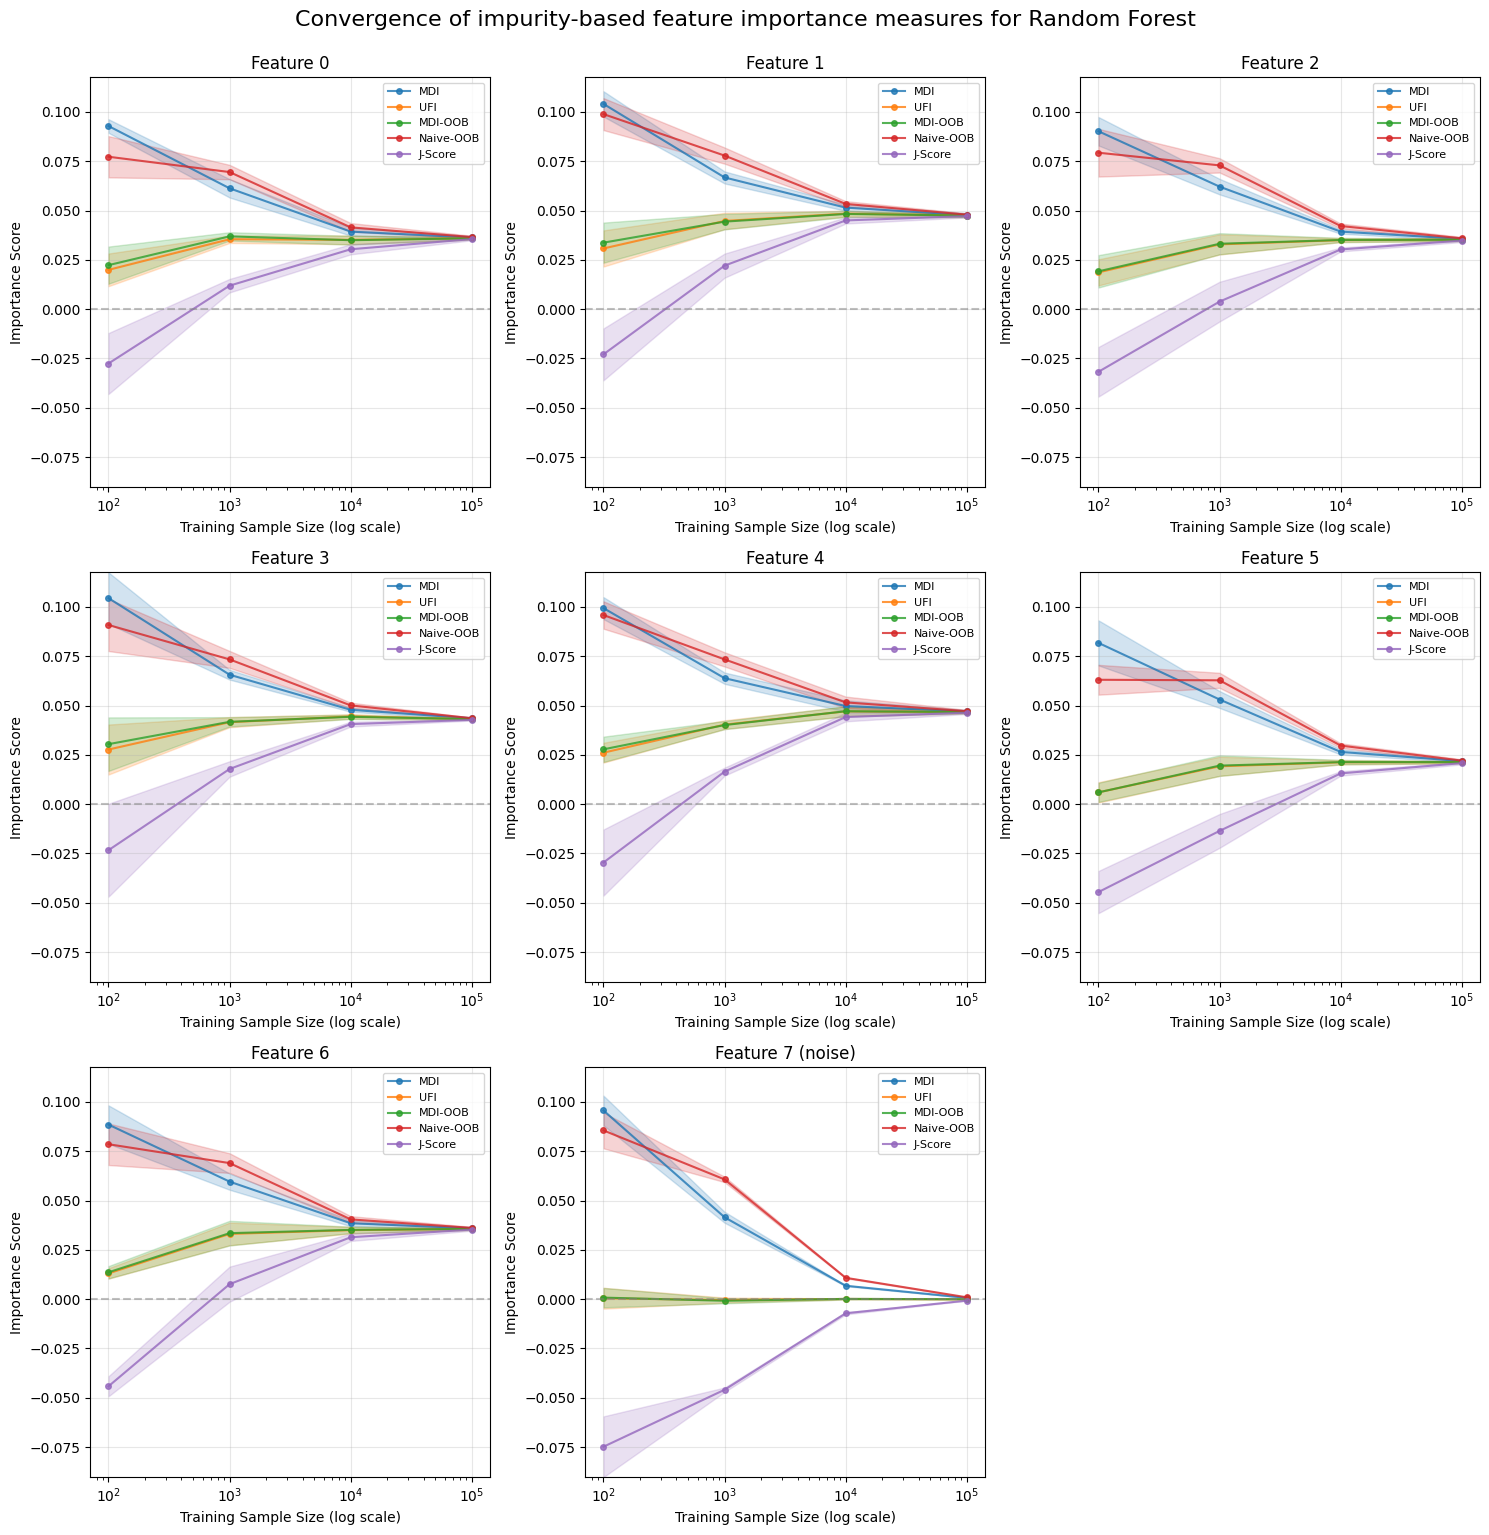

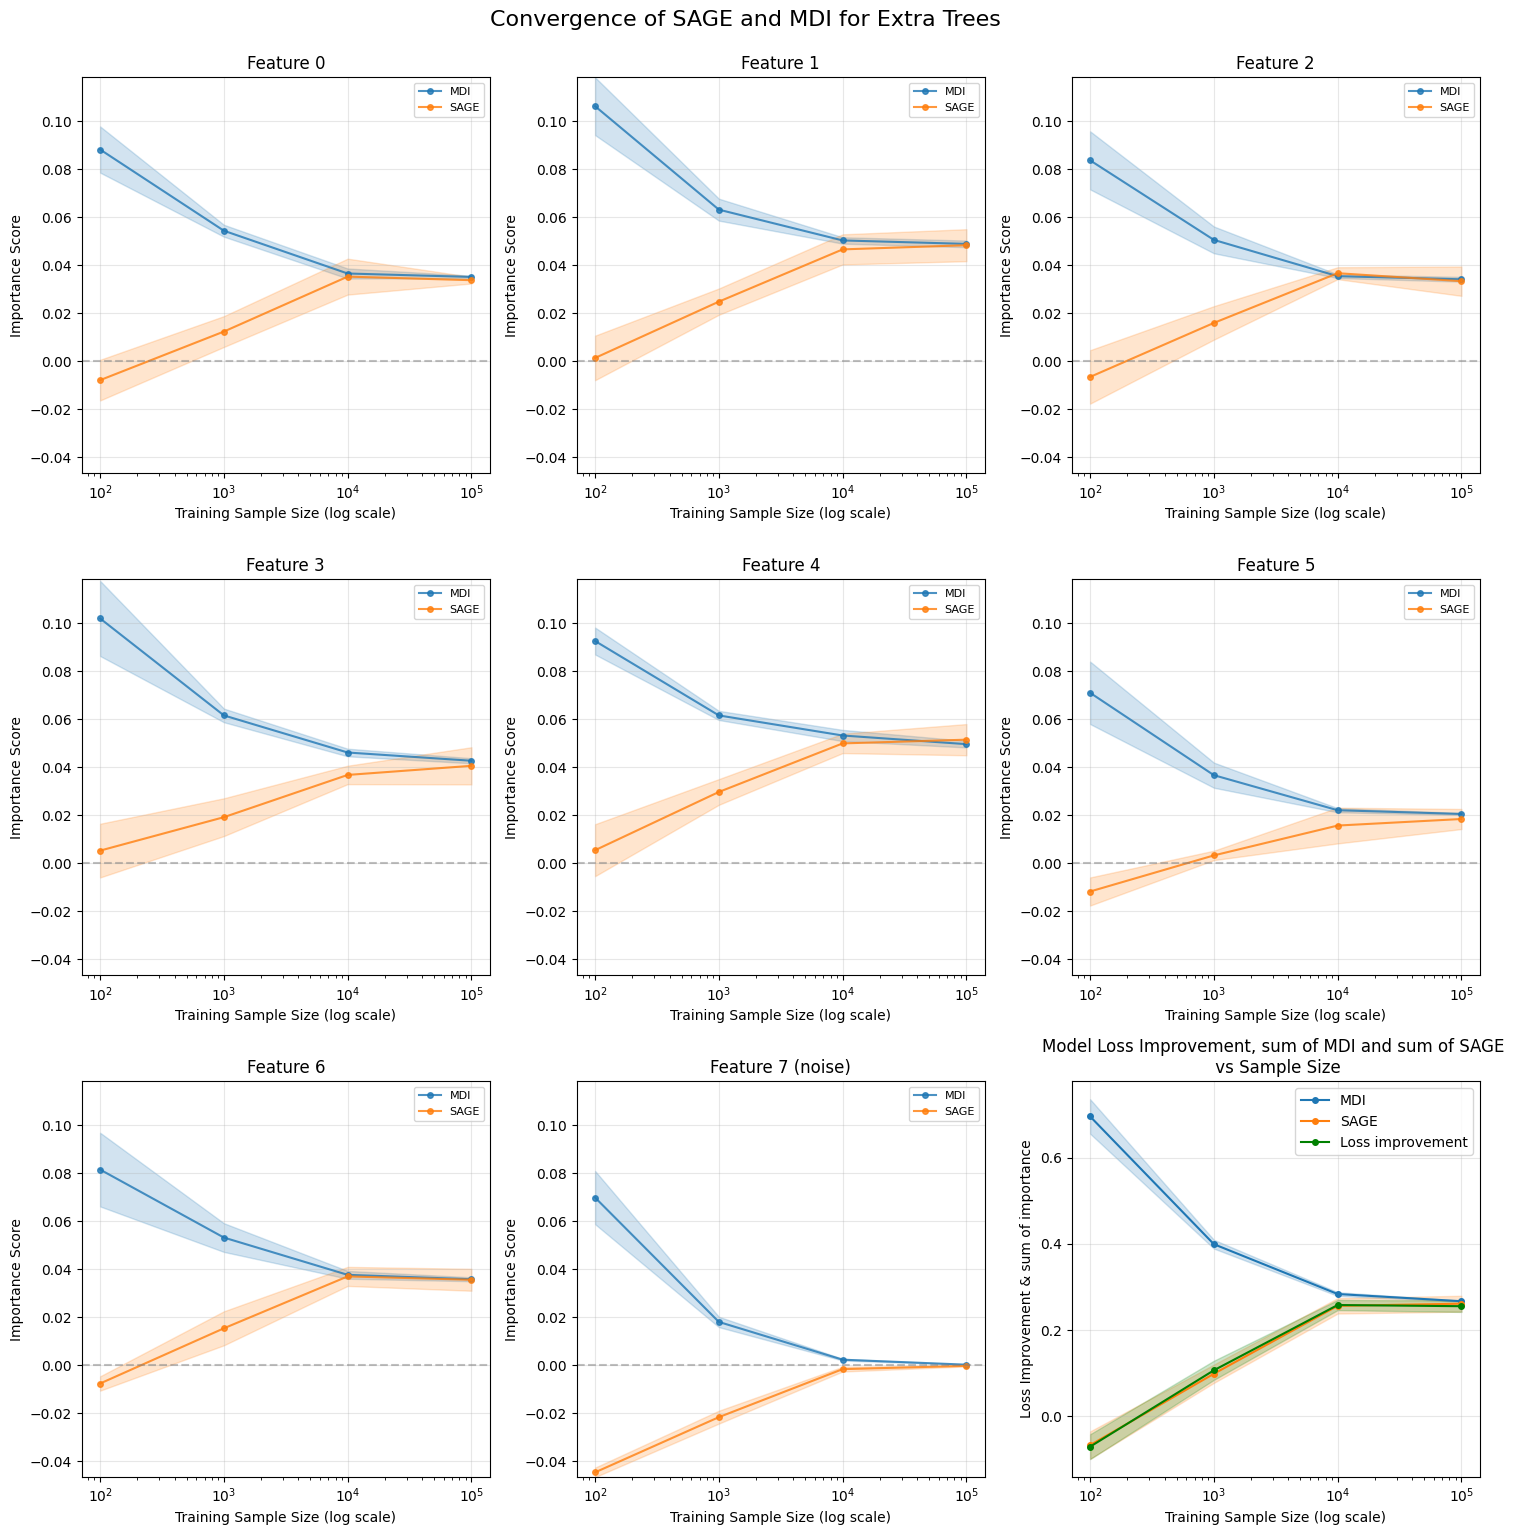

In [5]:

# Create plots
fig1, fig2 = plot_asymptotic_behavior(results)

# Add title and show
fig1.suptitle('Convergence of impurity-based feature importance measures for Random Forest', 
              fontsize=16, y=1.02)
fig2.suptitle('Convergence of SAGE and MDI for Extra Trees', 
              fontsize=16, y=1.02)
plt.show()
